In [52]:
import wrds
import warnings
import datetime
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [31]:
query = """
WITH last_trading_days AS (
    SELECT 
        DISTINCT DATE_TRUNC('month', dlycaldt) AS month,
        MAX(dlycaldt) OVER (PARTITION BY DATE_TRUNC('month', dlycaldt)) AS last_trading_day
    FROM 
        crsp.dsf_v2
    WHERE 
        dlycaldt BETWEEN '2013-12-01' AND '2023-12-31'
),
market_cap_data AS (
    SELECT 
        d.dlycaldt,
        d.permno,
        d.dlyclose,
        d.shrout,
        d.dlyclose * d.shrout * 1000 AS market_cap,
        left(s.cusip, 6) as cusip,
        s.comnam
    FROM 
        crsp.dsf_v2 as d
    JOIN
        crsp.stocknames as s on s.permno = d.permno and s.namedt <= d.dlycaldt and s.nameenddt >= d.dlycaldt 
    WHERE 
        dlycaldt BETWEEN '2013-12-01' AND '2023-12-31'
        AND dlyclose IS NOT NULL
),
eom_data AS (
    SELECT 
        a.dlycaldt,
        a.permno,
        a.dlyclose,
        a.shrout,
        a.market_cap,
        a.cusip,
        a.comnam,
        l.month
    FROM 
        market_cap_data a
    JOIN 
        last_trading_days l
    ON 
        a.dlycaldt = l.last_trading_day
),
agr_eom_data AS (
    SELECT
        cusip,
        comnam,
        dlycaldt,
        max(market_cap) as market_cap,
        month
    FROM
        eom_data
    GROUP BY
        cusip, comnam, dlycaldt, month
),
final_data AS (
    SELECT
        e.permno,
        a.cusip,
        a.comnam,
        a.dlycaldt,
        a.market_cap,
        a.month
    FROM
        agr_eom_data as a
    JOIN
        eom_data as e on e.cusip = a.cusip and e.market_cap = a.market_cap and e.dlycaldt = a.dlycaldt
)
SELECT 
    *
FROM 
    (
        SELECT 
            final_data.*,
            ROW_NUMBER() OVER (PARTITION BY month ORDER BY market_cap DESC) AS rank
        FROM 
            final_data
    ) ranked_data
WHERE 
    rank <= 5
ORDER BY 
    month, rank
"""

EOM_data = conn.raw_sql(query)

In [32]:
EOM_data['month'] = pd.to_datetime(EOM_data['dlycaldt']).dt.month

EOM_data

,permno,cusip,comnam,dlycaldt,market_cap,month,rank
0,14593,037833,APPLE INC,2013-12-31,5.006806e+11,12,1
1,11850,30231G,EXXON MOBIL CORP,2013-12-31,4.420936e+11,12,2
2,90319,02079K,GOOGLE INC,2013-12-31,3.130423e+11,12,3
3,10107,594918,MICROSOFT CORP,2013-12-31,3.105030e+11,12,4
4,12060,369604,GENERAL ELECTRIC CO,2013-12-31,2.835899e+11,12,5
...,...,...,...,...,...,...,...
600,14593,037833,APPLE INC,2023-12-29,2.994371e+12,12,1
601,10107,594918,MICROSOFT CORP,2023-12-29,2.794828e+12,12,2
602,84788,023135,AMAZON COM INC,2023-12-29,1.570153e+12,12,3
603,86580,67066G,NVIDIA CORP,2023-12-29,1.223193e+12,12,4


# 1.

In [33]:
EOY_data = EOM_data[EOM_data['month'] == 12]

EOY_data = EOY_data.reset_index(drop=True)

EOY_data

,permno,cusip,comnam,dlycaldt,market_cap,month,rank
0,14593,037833,APPLE INC,2013-12-31,5.006806e+11,12,1
1,11850,30231G,EXXON MOBIL CORP,2013-12-31,4.420936e+11,12,2
2,90319,02079K,GOOGLE INC,2013-12-31,3.130423e+11,12,3
3,10107,594918,MICROSOFT CORP,2013-12-31,3.105030e+11,12,4
4,12060,369604,GENERAL ELECTRIC CO,2013-12-31,2.835899e+11,12,5
5,14593,037833,APPLE INC,2014-12-31,6.431201e+11,12,1
6,11850,30231G,EXXON MOBIL CORP,2014-12-31,3.914822e+11,12,2
7,10107,594918,MICROSOFT CORP,2014-12-31,3.817261e+11,12,3
8,22111,478160,JOHNSON & JOHNSON,2014-12-31,2.927029e+11,12,4
9,38703,949746,WELLS FARGO & CO NEW,2014-12-31,2.843855e+11,12,5


In [34]:
#List of the unique companies that have been the top 5 largest by market cap at the EOY

EOY_data['comnam'].unique().tolist()

['APPLE INC',
 'EXXON MOBIL CORP',
 'GOOGLE INC',
 'MICROSOFT CORP',
 'GENERAL ELECTRIC CO',
 'JOHNSON & JOHNSON',
 'WELLS FARGO & CO NEW',
 'AMAZON COM INC',
 'FACEBOOK INC',
 'ALPHABET INC',
 'TESLA INC',
 'UNITEDHEALTH GROUP INC',
 'NVIDIA CORP']

# 2.

In [35]:
turnover = []
prev_top5 = set(EOM_data[0:5]['cusip'])

for date in EOM_data['dlycaldt'].unique():
    curr_top5 = set(EOM_data[EOM_data['dlycaldt'] == date]['cusip'])
    turnover_count = len(prev_top5.symmetric_difference(curr_top5))
    turnover_rate = turnover_count / 5
    turnover.append({'date': date, 'turnover_rate': turnover_rate})
    prev_top5 = curr_top5

turnover_df = pd.DataFrame(turnover)

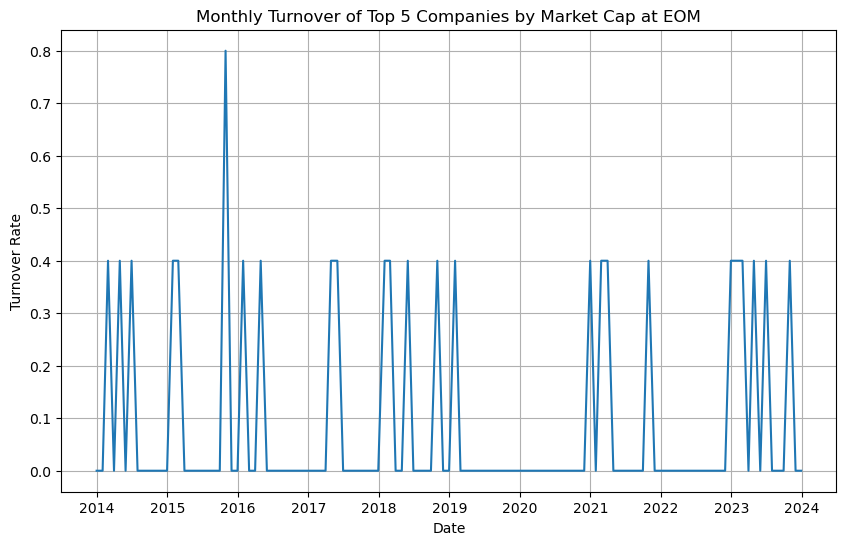

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(turnover_df['date'], turnover_df['turnover_rate'])
#plt.plot(test['dlycaldt'], test['dlyclose'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Turnover Rate')
plt.title('Monthly Turnover of Top 5 Companies by Market Cap at EOM')
plt.grid(True)
plt.show()

# 3.

In [101]:
non_pit = EOY_data[-5:]
non_pit['weights'] = non_pit['market_cap'] / non_pit['market_cap'].sum()

In [102]:
non_pit

,permno,cusip,comnam,dlycaldt,market_cap,month,rank,weights
50,14593,037833,APPLE INC,2023-12-29,2.994371e+12,12,1,0.318238
51,10107,594918,MICROSOFT CORP,2023-12-29,2.794828e+12,12,2,0.297030
52,84788,023135,AMAZON COM INC,2023-12-29,1.570153e+12,12,3,0.166874
53,86580,67066G,NVIDIA CORP,2023-12-29,1.223193e+12,12,4,0.129999
54,90319,02079K,ALPHABET INC,2023-12-29,8.266854e+11,12,5,0.087859


In [103]:
query = f"""
SELECT
    permno,
    date,
    ret
FROM
    crsp.dsf
WHERE
    permno IN ({', '.join(map(str, non_pit['permno'].to_list()))})
    AND date BETWEEN '2014-01-02' AND '2023-12-31'
ORDER BY
    permno, date
"""
nonpit_returns = conn.raw_sql(query)

In [104]:
nonpit_returns = pd.merge(nonpit_returns, non_pit, on='permno')
nonpit_returns['weighted_returns'] = nonpit_returns['weights'] * nonpit_returns['ret']
nonpit_returns['equal_weight_returns'] = nonpit_returns['ret'] * 0.2

nonpit_returns

,permno,date,ret,cusip,comnam,dlycaldt,market_cap,month,rank,weights,weighted_returns,equal_weight_returns
0,10107,2014-01-02,-0.006683,594918,MICROSOFT CORP,2023-12-29,2.794828e+12,12,2,0.297030,-0.001985,-0.001337
1,10107,2014-01-03,-0.006728,594918,MICROSOFT CORP,2023-12-29,2.794828e+12,12,2,0.297030,-0.001998,-0.001346
2,10107,2014-01-06,-0.021133,594918,MICROSOFT CORP,2023-12-29,2.794828e+12,12,2,0.297030,-0.006277,-0.004227
3,10107,2014-01-07,0.007750,594918,MICROSOFT CORP,2023-12-29,2.794828e+12,12,2,0.297030,0.002302,0.001550
4,10107,2014-01-08,-0.017852,594918,MICROSOFT CORP,2023-12-29,2.794828e+12,12,2,0.297030,-0.005303,-0.003570
...,...,...,...,...,...,...,...,...,...,...,...,...
12575,90319,2023-12-22,0.007620,02079K,ALPHABET INC,2023-12-29,8.266854e+11,12,5,0.087859,0.000669,0.001524
12576,90319,2023-12-26,0.000212,02079K,ALPHABET INC,2023-12-29,8.266854e+11,12,5,0.087859,0.000019,0.000042
12577,90319,2023-12-27,-0.008126,02079K,ALPHABET INC,2023-12-29,8.266854e+11,12,5,0.087859,-0.000714,-0.001625
12578,90319,2023-12-28,-0.000997,02079K,ALPHABET INC,2023-12-29,8.266854e+11,12,5,0.087859,-0.000088,-0.000199


In [105]:
nonpit = nonpit_returns.groupby('date')['weighted_returns'].sum()
nonpit_cumulative_return = (nonpit + 1).cumprod() - 1
nonpit_cumulative_return

date
2014-01-02    -0.008697
2014-01-03    -0.020423
2014-01-06    -0.023365
2014-01-07    -0.017786
2014-01-08    -0.017491
                ...    
2023-12-22    15.121876
2023-12-26    15.127721
2023-12-27    15.115964
2023-12-28    15.146608
2023-12-29    15.097691
Name: weighted_returns, Length: 2516, dtype: float64

In [114]:
dates = EOY_data['dlycaldt'].unique()
pit_returns_list = []

for i in range(0, len(dates) - 1):
    filtered_data = EOY_data[EOY_data['dlycaldt'] == dates[i]]
    filtered_data['weight'] = filtered_data['market_cap'] / filtered_data['market_cap'].sum()

    query = f"""
    SELECT
        permno,
        date,
        ret
    FROM
        crsp.dsf
    WHERE
        permno IN ({', '.join(map(str, filtered_data['permno'].to_list()))})
        AND date BETWEEN '{dates[i]}' AND '{dates[i + 1] - datetime.timedelta(days=1)}'
    ORDER BY
        permno, date
    """
    pit_returns = conn.raw_sql(query)

    pit_returns = pd.merge(pit_returns, filtered_data, on='permno')

    pit_returns['weighted_return'] = pit_returns['ret'] * pit_returns['weight']

    pit_returns['equal_weight_returns'] = pit_returns['ret'] * 0.2

    pit_returns_list.append(pit_returns)


In [115]:
pit_df = pd.concat(pit_returns_list, ignore_index=True)
pit_df

,permno,date,ret,cusip,comnam,dlycaldt,market_cap,month,rank,weight,weighted_return,equal_weight_returns
0,10107,2013-12-31,0.003218,594918,MICROSOFT CORP,2013-12-31,3.105030e+11,12,4,0.167848,0.000540,0.000644
1,10107,2014-01-02,-0.006683,594918,MICROSOFT CORP,2013-12-31,3.105030e+11,12,4,0.167848,-0.001122,-0.001337
2,10107,2014-01-03,-0.006728,594918,MICROSOFT CORP,2013-12-31,3.105030e+11,12,4,0.167848,-0.001129,-0.001346
3,10107,2014-01-06,-0.021133,594918,MICROSOFT CORP,2013-12-31,3.105030e+11,12,4,0.167848,-0.003547,-0.004227
4,10107,2014-01-07,0.007750,594918,MICROSOFT CORP,2013-12-31,3.105030e+11,12,4,0.167848,0.001301,0.001550
...,...,...,...,...,...,...,...,...,...,...,...,...
12575,92655,2023-12-21,0.007656,91324P,UNITEDHEALTH GROUP INC,2022-12-30,4.953732e+11,12,5,0.086459,0.000662,0.001531
12576,92655,2023-12-22,0.000827,91324P,UNITEDHEALTH GROUP INC,2022-12-30,4.953732e+11,12,5,0.086459,0.000072,0.000165
12577,92655,2023-12-26,-0.000538,91324P,UNITEDHEALTH GROUP INC,2022-12-30,4.953732e+11,12,5,0.086459,-0.000047,-0.000108
12578,92655,2023-12-27,0.005307,91324P,UNITEDHEALTH GROUP INC,2022-12-30,4.953732e+11,12,5,0.086459,0.000459,0.001061


In [116]:
pit = pit_df.groupby('date')['weighted_return'].sum()
pit_cumulative_return = (pit + 1).cumprod() - 1
pit_cumulative_return

date
2013-12-31    0.008318
2014-01-02   -0.004182
2014-01-03   -0.013139
2014-01-06   -0.014177
2014-01-07   -0.008089
                ...   
2023-12-21    4.608839
2023-12-22    4.603992
2023-12-26    4.598694
2023-12-27    4.594173
2023-12-28    4.605874
Name: weighted_return, Length: 2516, dtype: float64

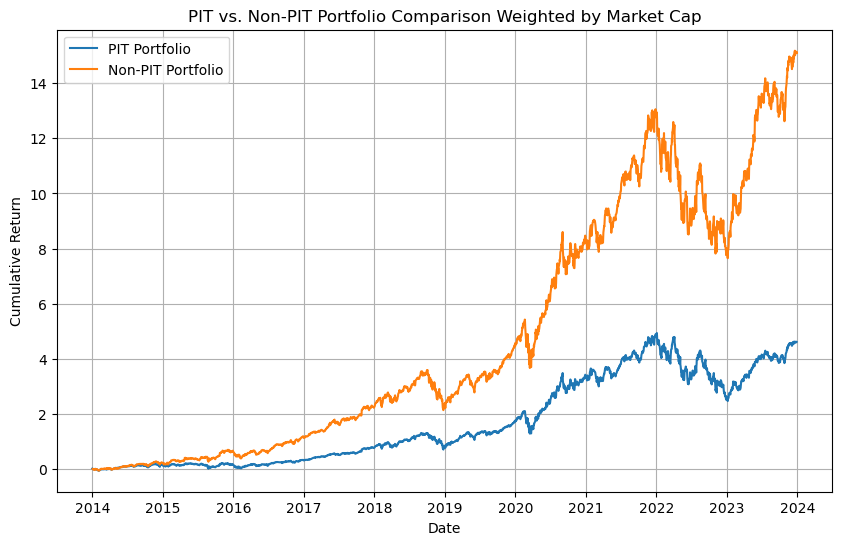

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(pit_cumulative_return, label='PIT Portfolio')
plt.plot(nonpit_cumulative_return, label='Non-PIT Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('PIT vs. Non-PIT Portfolio Comparison Weighted by Market Cap')
plt.grid(True)
plt.legend()
plt.show()

In [112]:
nonpit_equal = nonpit_returns.groupby('date')['equal_weight_returns'].sum()
nonpit_cumulative_return_equal = (nonpit_equal + 1).cumprod() - 1
nonpit_cumulative_return_equal

date
2014-01-02    -0.007913
2014-01-03    -0.018193
2014-01-06    -0.017843
2014-01-07    -0.008529
2014-01-08    -0.005758
                ...    
2023-12-22    16.709518
2023-12-26    16.733302
2023-12-27    16.709046
2023-12-28    16.733308
2023-12-29    16.674299
Name: equal_weight_returns, Length: 2516, dtype: float64

In [118]:
pit_equal = pit_df.groupby('date')['equal_weight_returns'].sum()
pit_cumulative_return_equal = (pit_equal + 1).cumprod() - 1
pit_cumulative_return_equal

date
2013-12-31    0.007794
2014-01-02   -0.004451
2014-01-03   -0.012241
2014-01-06   -0.014420
2014-01-07   -0.007497
                ...   
2023-12-21    3.542133
2023-12-22    3.543787
2023-12-26    3.541489
2023-12-27    3.536158
2023-12-28    3.543985
Name: equal_weight_returns, Length: 2516, dtype: float64

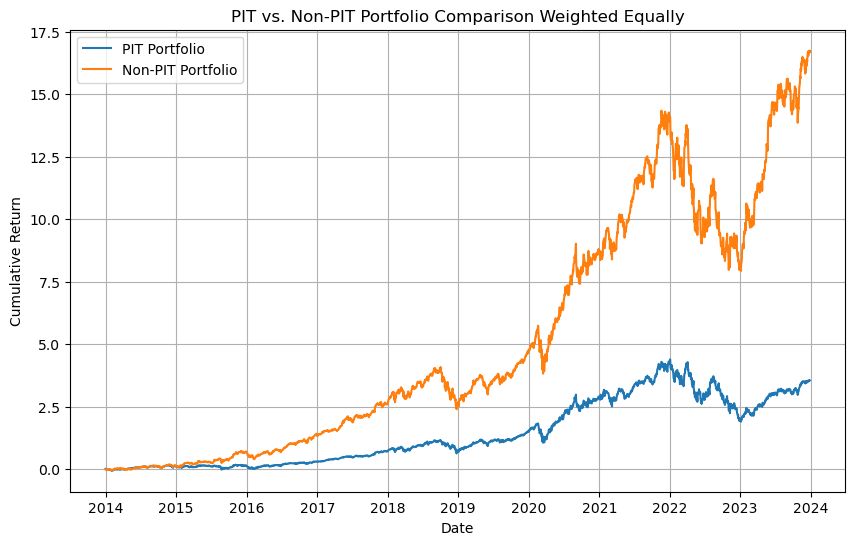

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(pit_cumulative_return_equal, label='PIT Portfolio')
plt.plot(nonpit_cumulative_return_equal, label='Non-PIT Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('PIT vs. Non-PIT Portfolio Comparison Weighted Equally')
plt.grid(True)
plt.legend()
plt.show()